# SHAP Values Example

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import shap
import warnings
warnings.filterwarnings('ignore')
plt.ioff()

## Reading and cleaning data

In [2]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
rating_factors_col =  list(df.columns[:-1])
claims_col = df.columns[-1]

rating_factors_encoded = pd.get_dummies(df[rating_factors_col])
rating_factors_encoded_col = list(rating_factors_encoded.columns)

X_train, X_test, y_train, y_test = train_test_split(
            rating_factors_encoded,
            df[claims_col],
            test_size=0.2,
            random_state=123
        )
X_train.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
67,40,26.315,1,0,1,1,0,0,1,0,0
736,37,38.390,0,1,0,0,1,0,0,1,0
310,50,26.600,0,0,1,1,0,0,0,0,1
963,46,24.795,3,0,1,1,0,1,0,0,0
680,21,17.400,1,1,0,1,0,0,0,0,1


## Multiple Linear Regression Model

In [7]:
# Fit a linear model, which ignores any form of interactions
lm = LinearRegression()
lm.fit(X_train, y_train)

# Note that this assumes that coefficients are all at a comparable scale
coeffs = zip(rating_factors_encoded_col, lm.coef_)
print("Model coefficients: \n")
for k, v in coeffs:
    print(k, "=", np.round(v, 2))
print("intercept: {}".format(np.round(lm.intercept_, 2)))

Model coefficients: 

age = 255.65
bmi = 342.68
children = 451.59
sex_female = 41.72
sex_male = -41.72
smoker_no = -11750.51
smoker_yes = 11750.51
region_northeast = 619.71
region_northwest = 200.49
region_southeast = -413.56
region_southwest = -406.64
intercept: -741.39


### Appendix1: Unit test - Regression calcs

In [ ]:
def test_linear_calcs(df, idx, model):
    inputs = np.array(df.iloc[idx, :])
    intercept = model.intercept_
    coef = model.coef_
    prediction = sum([f * c for (f, c) in zip(inputs, coef)]) + intercept
    return prediction

test_results = [test_linear_calcs(X_train, k, lm) for k in range(len(X_train))]
test_linear_calcs_checksum = sum(test_results - lm.predict(X_train))
assert test_linear_calcs_checksum <= 1.0E-7, "Calculation difference over threshold"

### Appendix2: Unit test - SHAP reasonableness check

In [ ]:
# write test here

## Lienar Regression - PD Plots

In [ ]:
# PDP for linear model
# Write function plot_pdp

feature = "bmi"
shap.plots.partial_dependence(
    feature, 
    lm.predict,
    X_train,
    ice=False,
    model_expected_value=True, 
    feature_expected_value=True
)

In [ ]:
# Just re-iterating that model's mean prediction is the global average

print(y_train.mean())
print(lm.predict(X_train).mean())

In [10]:
# Masker method masks out features by integrating over the given background data
# Recall that the SHAP approach requires the 2^F super set of models 
background = shap.maskers.Independent(X_train, max_samples=2000)

# Instantiate a linear explainer object with the SLR model and independent masker
explainer = shap.LinearExplainer(lm, background)
shap_values = explainer(X_train)

In [17]:
# Quick check for shap.base_values (null model) = global average

# print(shap_values.base_values.mean())
print(lm.predict(X_train).mean())

13189.257683065422


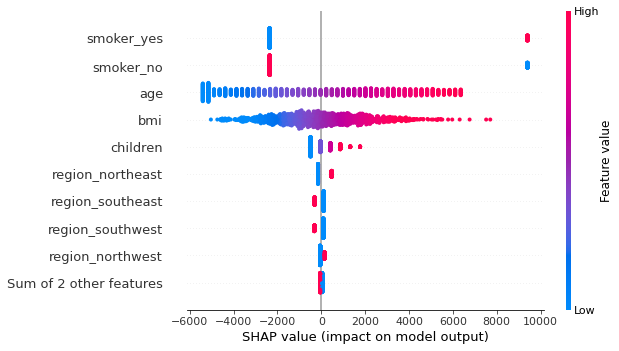

In [18]:
# Do we put this in? or too cluttered
shap.plots.beeswarm(shap_values)

In [12]:
idx = 1

In [ ]:
df.iloc[X_train.iloc[idx, :].name, :]

In [ ]:
lm.predict(X_train)[idx]

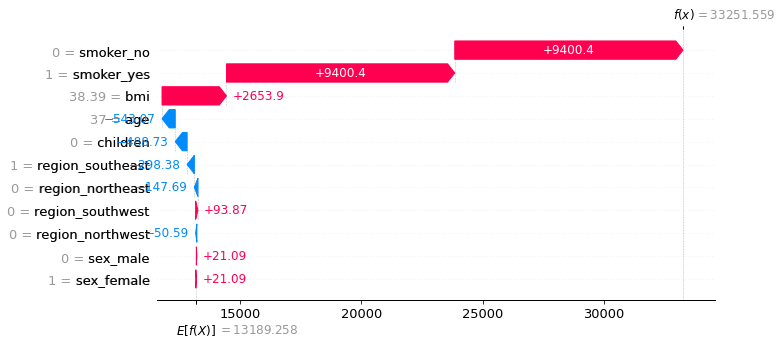

In [16]:
idx = 1
shap.plots.waterfall(shap_values[idx], max_display=14, show=False)
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.show()

## GBM interpretation